<a href="https://colab.research.google.com/github/Nikhil-Kadapala/NeuralNets/blob/main/standardNeuralNets/stdCNN_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project CS852 - Foundations of Neural Networks (FALL 2024)

Devin Borchard and Nikhil Kadapala

Department of Computer Science, University of New Hampshire

Nikhil.Kadapala@unh.edu     Devin.Borchard@unh.edu

This project explores the application of Convolutional Neural Networks (CNNs) for sentiment analysis and Interpretability using the LIME (Local Interpretable Model-agnostic Explanations) Evaluation.

The project uses the Movie Reviews dataset from the Eraser Benchmark.

The goal of this project is to evaluate the performance of CNNs for sentiment analysis and explain their predictions using LIME.

We will explore the integration of LIME Explanations as a feedback to measure the alignment of the model's reasoning with human rationales extracted from the annotations in the Dataset.

Based on the alignment scores, we will retrain the model by adjusting the weights of the features to teach the model to rationalize as closely possible to a human.

ERASER: [Datasets](https://www.eraserbenchmark.com) and [Paper](https://arxiv.org/pdf/1911.03429)

LIME: [Paper](https://arxiv.org/pdf/1602.04938) and  [Library/Package GitHub](https://github.com/marcotcr/lime)

# Notebook setup and PyTorch Installation

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# uncomment one of these versions (depending on whether you are on a computer with a CPU or not)

# GPU version
# !conda install --yes --prefix {sys.prefix} pytorch torchvision cudatoolkit=10.2 -c pytorch

# Just CPU
# !conda install --yes --prefix {sys.prefix} pytorch torchvision cpuonly -c pytorch

# install `Einops` for einstein-style tensor manipulation in pytorch
# Also see https://github.com/arogozhnikov/einops
# !conda install --yes --prefix {sys.prefix} einops  -c conda-forge

# install lime
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=69ea5cf19faa86a6e43ce7a764eec57ef987ce75d6290b8fa4081e1581e172f5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
# torch test
import torch
x = torch.rand(5, 3)
print(x)

print("GPU/CUDA available? ", torch.cuda.is_available())

print("Torch version", torch.__version__)

tensor([[0.7711, 0.6733, 0.7155],
        [0.3169, 0.0668, 0.3512],
        [0.2129, 0.9355, 0.2797],
        [0.0037, 0.8028, 0.7981],
        [0.2394, 0.2700, 0.3398]])
GPU/CUDA available?  True
Torch version 2.5.1+cu121


In [3]:
#!git clone https://github.com/Nikhil-Kadapala/NeuralNets.git

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Extracting Traning, Validation, and Test Data**
# Parse the data files to extract the reviews, classifications and annotations for each split.

There are three files:
- train.jsonl: containts 1600 training examples
- val.jsonl: contains 200 validation examples
- test.json: contains 199 test examples

Each example includes:
- annotation_id: a unique id for an example of the form negR_000 for negative examples and posR_000 for positive examples.
- evidences: a list of rationales(specific parts of the review) given by humans that most influenced their classification decision.
- classification: the class of the example

The annotation_id of each example is the name of the file for the input text data
    

In [17]:
import json

def parse_data(file_path):
    data = []                                               # Initialize an empty list to store the dictionaries

    with open(file_path, 'r') as file:                      # Open the .jsonl file and read it line by line
        for line in file:
            annotation = json.loads(line)                   # Parse each line as JSON and append it to the list
            id = annotation["annotation_id"]
            annotation["classification"] = 1 if annotation['classification'] == "POS" else 0

            with open(f"./drive/MyDrive/NeuralNets/standardNeuralNets/movies/docs/{id}", 'r') as file:  # open the file named by annotation_id to extract the review text
                content = file.read()
                annotation['content'] = content.replace('\n', ' ')
                data.append(annotation)
    return data

# Specify the path to your JSON file
train_file_path = './drive/MyDrive/NeuralNets/standardNeuralNets/movies/train.jsonl'
val_file_path = './drive/MyDrive/NeuralNets/standardNeuralNets/movies/val.jsonl'
test_file_path = './drive/MyDrive/NeuralNets/standardNeuralNets/movies/test.jsonl'

train_data = parse_data(train_file_path)
validation_data = parse_data(val_file_path)
test_data = parse_data(test_file_path)

# Functions to extract reviews, classifications, and annotations
  Define a function

  i) to retrieve an example and print the relevant information.

  ii) to retrieve the content of the example review text

  iii) to retrieve the classifications of the examples
  
  iv) to retrieve the annotations provided to support the classifications

In [18]:
def print_example(data, index, print_content=True, print_classification=True, print_rationales=True ):
    print(f'Retrieving Training Example [{index}].................\n')
    item = data[index]
    classification = item['classification']
    evidences = item['evidences']
    content = item['content']
    if print_content: print(f'Review content:\n{content}\n')
    if print_classification: print('----------------------------',
                                   '\n| Sentiment class:',
                                   classification,
                                   ("- NEG" if not classification else "- POS"),
                                   '|', '\n----------------------------')
    if print_rationales:
        print('\nHuman rationales / Supporting Evidence:')
        for evidence in evidences:
            print('     - ', evidence[0]['text'])

def get_content(data, index):
    item = data[index]
    content = item['content']
    return content

def get_classes(data, index):
    item = data[index]
    classification = item['classification']
    return classification

def get_annotations(data, index):
    item = data[index]
    content = item['evidences']
    annotations = [evidence[0]['text'] for evidence in content]
    return annotations

train_size = len(train_data)
val_size = len(validation_data)
test_size = len(test_data)

print(f'Dataset split: {train_size} training examples')
print(f'               {val_size} validation examples')
print(f'               {test_size} test examples\n')

print_example(train_data, 506)

Dataset split: 1600 training examples
               200 validation examples
               199 test examples

Retrieving Training Example [506].................

Review content:
this film is extraordinarily horrendous and i 'm not going to waste any more words on it .

---------------------------- 
| Sentiment class: 0 - NEG | 
----------------------------

Human rationales / Supporting Evidence:
     -  extraordinarily horrendous


# Extraction of the rationales from the evidences metadata of each human annotation of reviews.

Each annotation of the review is not the highlighted text/rationale itself but also contains metadata of the text. Use the function defined in the above cell to extract just the text and replace the evidences dictionary of the training, validation, and test datasets.

In [19]:
for i in range(len(train_data)):
    train_data[i]['evidences'] = get_annotations(train_data, i)

for i in range(len(validation_data)):
    validation_data[i]['evidences'] = get_annotations(validation_data, i)

for i in range(len(test_data)):
    test_data[i]['evidences'] = get_annotations(test_data, i)

print(train_data[506]['evidences'])

['extraordinarily horrendous']


# Pre-trianed GloVe Embeddings of Training Examples
Download the pretrained GloVe Embeddings of desired dimensions using gensim downlader.

Save downloaded embeddings to a local file to avoid re-downloading when the kernel or notebook is restarted.

In [ ]:
"""
    Install gensim, to use word2vec word embeddings
    Install gensim (for pre-trained word embeddings)
    #!conda install --yes --prefix {sys.prefix} gensim
"""
#import gensim
#import gensim.downloader

"""
    ONLY if you get an error after `import gensim`: update your smart_open liberary
    #!conda install --yes --prefix {sys.prefix} smart_open
    restart your notebook
    see if `import gensim` works now
"""
#wv = gensim.downloader.load("glove-wiki-gigaword-50")

#import pickle

#with open("glove_embeddings.pkl", "wb") as f:
    #pickle.dump(wv, f)


In [20]:
import pickle

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/glove_embeddings.pkl", "rb") as f:
    wv = pickle.load(f)

# lookup the word vector for a word "india"
wv['india']

array([-0.20356 , -0.8707  , -0.19172 ,  0.73862 ,  0.18494 ,  0.14926 ,
        0.48079 , -0.21633 ,  0.72753 , -0.36912 ,  0.13397 , -0.1143  ,
       -0.18075 , -0.64683 , -0.18484 ,  0.83575 ,  0.48179 ,  0.76026 ,
       -0.50381 ,  0.80743 ,  1.2195  ,  0.3459  ,  0.22185 ,  0.31335 ,
        1.2066  , -1.8441  ,  0.14064 , -0.99715 , -1.1402  ,  0.32342 ,
        3.2128  ,  0.42708 ,  0.19504 ,  0.80113 ,  0.38555 , -0.12568 ,
       -0.26533 ,  0.055264, -1.1557  ,  0.16836 , -0.82228 ,  0.20394 ,
        0.089235, -0.60125 , -0.032878,  1.3735  , -0.51661 ,  0.29611 ,
        0.23951 , -1.3801  ], dtype=float32)

# Extract reviews, classifications, and rationales from the train, validation, and test datasets to convert them to Glove embeddings.

In [21]:
# convert the training dataset to a pandas dataframe
train_df = pd.DataFrame(train_data)
train_df.drop(columns=['query', 'query_type'], inplace=True)
train_df['evidences'] = train_df['evidences'].astype(str)

train_rationales = train_df['evidences']
train_reviews = [get_content(train_data, i) for i in range(train_size)]
train_classes = torch.tensor([get_classes(train_data, i) for i in range(train_size)], dtype=torch.float)
train_classes = torch.stack([train_classes, 1 - train_classes], dim=1) # convert the classes to binary tensor for two classes (pos & neg)
print("Number of reviews in training data:",len(train_reviews))
print("Max seq length of reviews:", np.max([len(review.split()) for review in train_reviews]))
print("Size of training classes:", train_classes.size())
train_df.to_csv('./drive/MyDrive/NeuralNets/standardNeuralNets/train_data.csv', index=False)
train_df.head()

Number of reviews in training data: 1600
Max seq length of reviews: 2809
Size of training classes: torch.Size([1600, 2])


,annotation_id,classification,evidences,content
0,negR_000.txt,0,"['mind - fuck movie', 'the sad part is', 'down...","plot : two teen couples go to a church party ,..."
1,negR_001.txt,0,"[""it 's pretty much a sunken ship"", 'sutherlan...",the happy bastard 's quick movie review damn t...
2,negR_002.txt,0,['the characters and acting is nothing spectac...,it is movies like these that make a jaded movi...
3,negR_003.txt,0,"['dead on arrival', 'the characters stink', 's...",""" quest for camelot "" is warner bros . ' first..."
4,negR_004.txt,0,['it is highly derivative and somewhat boring'...,synopsis : a mentally unstable man undergoing ...


In [22]:
# convert the validation dataset to a pandas dataframe
val_df = pd.DataFrame(validation_data)
val_df.drop(columns=['query', 'query_type'], inplace=True)
val_df['evidences'] = val_df['evidences'].astype(str)

val_rationales = val_df['evidences']
val_reviews = [get_content(validation_data, i) for i in range(val_size)]
val_classes = torch.tensor([get_classes(validation_data, i) for i in range(val_size)], dtype=torch.float)
val_classes = torch.stack([val_classes, 1 - val_classes], dim=1) # convert the classes to binary tensor for two classes (pos & neg)

print("Number of reviews in validation data:",len(val_reviews))
print("Max seq length of reviews:", np.max([len(review.split()) for review in val_reviews]))
val_df.to_csv('./drive/MyDrive/NeuralNets/standardNeuralNets/val_data.csv', index=False)
val_df.head()

Number of reviews in validation data: 200
Max seq length of reviews: 1880


,annotation_id,classification,evidences,content
0,negR_800.txt,0,['definitely the cinematic equivalent of a sle...,there were four movies that earned jamie lee c...
1,negR_801.txt,0,"['overacts his psycho routine', 'deteriorates ...",according to hitchcock and various other filmm...
2,negR_802.txt,0,"['so dull and pedestrian and nonsensical', 'bo...",if you 've been following william fichtner 's ...
3,negR_803.txt,0,"['takes the easy route out', 'most hampered no...",note : some may consider portions of the follo...
4,negR_804.txt,0,"['poor choices', ""it 's downright depressing"",...","for his directoral debut , gary oldman chose a..."


In [23]:
# convert the test dataset to a pandas dataframe
test_df = pd.DataFrame(test_data)
test_df.drop(columns=['docids','query', 'query_type'], inplace=True)
test_df['evidences'] = test_df['evidences'].astype(str)

test_rationales = test_df['evidences']
test_reviews = [get_content(test_data, i) for i in range(test_size)]
test_classes = torch.tensor([get_classes(test_data, i) for i in range(test_size)], dtype=torch.float)
test_classes = torch.stack([test_classes, 1 - test_classes], dim=1) # convert the classes to binary tensor for two classes (pos & neg)

print("Number of reviews in test data:",len(test_reviews))
print("Max seq length of reviews:", np.max([len(review.split()) for review in test_reviews]))
test_df.to_csv('./drive/MyDrive/NeuralNets/standardNeuralNets/test_data.csv', index=False)
test_df.head()

Number of reviews in test data: 199
Max seq length of reviews: 2122


,annotation_id,classification,evidences,content
0,negR_900.txt,0,['i even giggled'],there may not be a critic alive who harbors as...
1,negR_901.txt,0,['rings'],"renee zellweger stars as sonia , a young jewis..."
2,negR_902.txt,0,"[""there 're so many things to criticize about ...",there 're so many things to criticize about i ...
3,negR_903.txt,0,"[""do n't let this movie fool you into believin...",do n't let this movie fool you into believing ...
4,negR_904.txt,0,"[""is proof that hollywood does n't have a clue...",it 's a good thing most animated sci - fi movi...


Extract validation set from the val.jsonl file and create a dataframe for it similar to the training set and save it to a csv file.

# Convert the reviews & rationales to their corresponding Glove embeddings

In [24]:
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

def create_glove_dict(sequence, wv, set, embed_dim=50):
    """
    Creates a dictionary mapping words in the vocabulary to their GloVe embeddings.
    Words that don't exist are mapped to zero vectors.
    """
    glove_dict = {}
    empty_vec = np.zeros(embed_dim, dtype=np.float64)

    for word in tqdm(sequence, desc=f"Building {set} GloVe dictionary"):
        glove_dict[word] = wv[word] if word in wv else empty_vec

    return glove_dict

def get_w2GloVe(data, glove_dict, set, embed_dim=50, rationale=False):
    """
    Retrieves the GloVe embeddings using the custom-built GloVe dictionary.
    Args:
        data: List of text reviews.
        glove_dict (dict): custom-built GloVe dictionary.
        embed_dim (int): Dimensions of GloVe embeddings.
    Returns:
        torch.Tensor: Padded tensor of GloVe embeddings to maintain uniform length.
    """
    glove_reviews = []

    if rationale:
        for review in tqdm(data, desc=f"Retrieving {set} GloVe Word Embeddings"):
            tokens = ",".join(review)
            words = tokens.split()
            embeddings = [glove_dict.get(word, np.zeros(embed_dim)) for word in words]
            glove_reviews.append(torch.tensor(embeddings, dtype=torch.float))
    else:
        for review in tqdm(data, desc=f"Retrieving {set} GloVe Word Embeddings"):
            words = review.split()
            embeddings = [glove_dict.get(word, np.zeros(embed_dim)) for word in words]
            glove_reviews.append(torch.tensor(embeddings, dtype=torch.float))

    return pad_sequence(glove_reviews, batch_first=True)

In [ ]:
"""
print(f"----------------------------------------------------------------------------------------\nProcessing Reviews\n----------------------------------------------------------------------------------------\n")

# Extract vocabulary(distinct words) from training, validation, and test data
train_vocab = set(word for review in train_df['content'] for word in review.split())
val_vocab = set(word for review in val_df['content'] for word in review.split())
test_vocab = set(word for review in test_df['content'] for word in review.split())

# Build the GloVe dictionary for the reviews
glove_dict = create_glove_dict(train_vocab, wv, "training")
glove_dict.update(create_glove_dict(val_vocab, wv, "validation"))
glove_dict.update(create_glove_dict(test_vocab, wv, "test"))

# Convert reviews to glove embeddings
train_review_gloves = get_w2GloVe(train_df['content'], glove_dict, "training")
val_review_gloves = get_w2GloVe(val_df['content'], glove_dict, "validation")
test_review_gloves = get_w2GloVe(test_df['content'], glove_dict, "test")

print(f"\n----------------------------------------------------------------------------------------\nProcessing Rationales\n----------------------------------------------------------------------------------------\n")

#Extract vocabulary(distinct words) from training, validation, and test data for the rationales
train_rationale_vocab = set(word for rationale in train_rationales for word in rationale.split())
val_rationale_vocab = set(word for rationale in val_rationales for word in rationale.split())
test_rationale_vocab = set(word for rationale in test_rationales for word in rationale.split())

# Build the GloVe dictionary for the rationales
dict_rat = create_glove_dict(train_rationale_vocab, wv, "training")
dict_rat.update(create_glove_dict(val_rationale_vocab, wv, "validation"))
dict_rat.update(create_glove_dict(test_rationale_vocab, wv, "test"))

# Convert rationales to glove embeddings
train_rationale_gloves = get_w2GloVe(train_rationales, glove_dict, "training", rationale=True)
val_rationale_gloves = get_w2GloVe(val_rationales, glove_dict, "validation", rationale=True)
test_rationale_gloves = get_w2GloVe(test_rationales, glove_dict, "test", rationale=True)
"""

Save the GloVe embeddings to local files for faster Access.

In [25]:
from torch import Tensor
from typing import Dict, List, Optional, Tuple, Union
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
"""
with open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_reviews.pkl", "wb") as f:
    pickle.dump(train_review_gloves, f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_reviews.pkl", "wb") as f:
    pickle.dump(val_review_gloves, f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_reviews.pkl", "wb") as f:
    pickle.dump(test_review_gloves, f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_rationales.pkl", "wb") as f:
    pickle.dump(train_rationale_gloves, f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_rationales.pkl", "wb") as f:
    pickle.dump(val_rationale_gloves, f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_rationales.pkl", "wb") as f:
    pickle.dump(test_rationale_gloves, f)
"""

'\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_reviews.pkl", "wb") as f:\n    pickle.dump(train_review_gloves, f)\n\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_reviews.pkl", "wb") as f:\n    pickle.dump(val_review_gloves, f)\n\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_reviews.pkl", "wb") as f:\n    pickle.dump(test_review_gloves, f)\n\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_rationales.pkl", "wb") as f:\n    pickle.dump(train_rationale_gloves, f)\n\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_rationales.pkl", "wb") as f:\n    pickle.dump(val_rationale_gloves, f)\n\nwith open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_rationales.pkl", "wb") as f:\n    pickle.dump(test_rationale_gloves, f)\n'

# Extract the GloVe embeddings created above and a create a copy before batching them.

In [26]:
with open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_reviews.pkl", "rb") as f:
    train_in = pickle.load(f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/train_rationales.pkl", "rb") as f:
    train_ev = pickle.load(f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_reviews.pkl", "rb") as f:
    val_in = pickle.load(f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/val_rationales.pkl", "rb") as f:
    val_ev = pickle.load(f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_reviews.pkl", "rb") as f:
    test_in = pickle.load(f)

with open("./drive/MyDrive/NeuralNets/standardNeuralNets/test_rationales.pkl", "rb") as f:
    test_ev = pickle.load(f)

In [27]:
print(train_in.size())
print(train_ev.size())
print(train_classes.size())

train_in[507].size()

torch.Size([1600, 2809, 50])
torch.Size([1600, 300, 50])
torch.Size([1600, 2])


torch.Size([2809, 50])

Convert the training, validation, and test data(GloVe representations) including the rationales to batches using DataLoader

In [28]:
train_inputs = TensorDataset(train_in, train_ev, train_classes)
val_inputs = TensorDataset(val_in, val_ev, val_classes)
test_inputs = TensorDataset(test_in, test_ev, test_classes)

train_loader = DataLoader(train_inputs, batch_size=32, shuffle=False)
val_loader = DataLoader(val_inputs, batch_size=25, shuffle=False)
test_loader = DataLoader(test_inputs, batch_size=25, shuffle=False, drop_last=False)

In [29]:
train_inp, train_evi, train_classg = next(iter(train_loader))
print(train_inp.size())
print(train_evi.size())
print(train_classg.size())


torch.Size([32, 2809, 50])
torch.Size([32, 300, 50])
torch.Size([32, 2])


# Convolutional Neural Network Model

In [41]:
from typing import List, Optional, Tuple, Union
from torch import Tensor
import torch.nn as nn
import lime
from lime.lime_text import LimeTextExplainer # type: ignore

class LIME_CNN(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        cnn_config: List[Dict],
        num_classes: int = 2,
        ) -> None:

        super(LIME_CNN, self).__init__()

        self.in_channels = embed_dim

        self.num_classes = num_classes

        self.config = cnn_config

        self.cnn_layers = nn.ModuleList()

        self.dropout = nn.Dropout(0.5)

        for index, config in enumerate(cnn_config):

          if index == 0:
              self.proj = nn.Linear(embed_dim, config['out_channels'])
              self.in_channels = config['out_channels']

          conv_layer = nn.Conv1d(
                in_channels=self.in_channels,
                out_channels=config['out_channels'],
                kernel_size=config['kernel_size'],
                stride=config['stride'],
                padding=config['padding'],
                bias=config['bias'],
                )

          self.cnn_layers.append(conv_layer)

          maxPool_layer = nn.MaxPool1d(
              kernel_size=config['kernel_size'],
              stride=config['stride'],
              padding=config['padding'],
              )

          self.cnn_layers.append(maxPool_layer)
          self.in_channels = config['out_channels']
          if index == 2 or index == 3:
              break

        self.relu = nn.ReLU()

        self.fc_layer = nn.Linear(self.in_channels, self.num_classes)

        self.class_names = ['Positive', 'Negative']

        self.lime_explainer = LimeTextExplainer(class_names=self.class_names)

    def forward(self, X: Tensor,) -> Tensor:
      X = self.proj(X)
      X = X.permute(0, 2, 1)

      for layer in self.cnn_layers:
        X = self.relu(layer(X)) if isinstance(layer, nn.Conv1d) else layer(X)
        X = self.dropout(X)
        X = X.mean(dim=-1)
        y_hat = self.fc_layer(X)
        return y_hat

    # define the classifier function that outputs the probabilities for both classes from the predicted probability of the examples
    # Refer to the following link for more information: https://www.geeksforgeeks.org/understanding-the-predictproba-function-in-scikit-learns-svc/

    def predict_proba(self, instance_idx):
        self.eval()
        with torch.no_grad():
            print("input received in predict_proba:", instance_idx)
            preds = self.forward(train_in[instance_idx])
            print("Output from predict_proba:", preds)
            probabs = preds.numpy()
            #probabs = np.hstack([probabs[0], probabs[1]])
            return probabs

    def get_lime_explanation(self, instance_idx, num_features: int):
        explanation = self.lime_explainer.explain_instance(train_reviews[instance_idx], self.predict_proba, num_features=num_features)
        return explanation

In [51]:
import json
# Load the model configuration from a JSON file
with open("./drive/MyDrive/NeuralNets/standardNeuralNets/model_config.json", "r") as f:
    loaded_config = json.load(f)

def simple_train_model(model, train_set, val_set, optimizer, criterion, n_epochs, lr):
  train_losses = []
  all_preds = []
  preds_tensor = torch.zeros(train_size, 2)

  for epoch in range(n_epochs):
    model.train()
    avg_train_loss = 0.0
    preds_list = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
      inputs, rationales, labels = batch
      pred = model(inputs)
      preds_list.append(pred)

      loss = criterion(pred, labels)
      avg_train_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      all_preds = preds_list


    avg_train_loss /= train_size
    train_losses.append(avg_train_loss)
    preds_tensor = torch.cat(all_preds, dim=0)
    print(f"Training Loss: {avg_train_loss:.4f}")

  return preds_tensor, train_losses

model = LIME_CNN(embed_dim=50, cnn_config=loaded_config, num_classes=2)
lr, n_epochs = 1e-3, 15
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

preds, loss_list = simple_train_model(model=model, train_set=train_loader, val_set=val_loader, optimizer=optimizer, criterion=loss, n_epochs=n_epochs, lr=lr)


Epoch 1/15: 100%|██████████| 50/50 [00:02<00:00, 23.43it/s]


Training Loss: 0.0298


Epoch 2/15: 100%|██████████| 50/50 [00:02<00:00, 17.70it/s]


Training Loss: 0.0221


Epoch 3/15: 100%|██████████| 50/50 [00:02<00:00, 19.04it/s]


Training Loss: 0.0220


Epoch 4/15: 100%|██████████| 50/50 [00:02<00:00, 18.62it/s]


Training Loss: 0.0220


Epoch 5/15: 100%|██████████| 50/50 [00:02<00:00, 24.15it/s]


Training Loss: 0.0220


Epoch 6/15: 100%|██████████| 50/50 [00:02<00:00, 24.51it/s]


Training Loss: 0.0219


Epoch 7/15: 100%|██████████| 50/50 [00:02<00:00, 24.02it/s]


Training Loss: 0.0219


Epoch 8/15: 100%|██████████| 50/50 [00:02<00:00, 21.75it/s]


Training Loss: 0.0219


Epoch 9/15: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s]


Training Loss: 0.0219


Epoch 10/15: 100%|██████████| 50/50 [00:02<00:00, 24.23it/s]


Training Loss: 0.0219


Epoch 11/15: 100%|██████████| 50/50 [00:02<00:00, 21.52it/s]


Training Loss: 0.0219


Epoch 12/15: 100%|██████████| 50/50 [00:02<00:00, 20.67it/s]


Training Loss: 0.0219


Epoch 13/15: 100%|██████████| 50/50 [00:02<00:00, 22.01it/s]


Training Loss: 0.0218


Epoch 14/15: 100%|██████████| 50/50 [00:02<00:00, 21.32it/s]


Training Loss: 0.0218


Epoch 15/15: 100%|██████████| 50/50 [00:02<00:00, 18.97it/s]

Training Loss: 0.0218


# Training Loop

In [43]:
import json
# Load the model configuration from a JSON file
with open("./drive/MyDrive/NeuralNets/standardNeuralNets/model_config.json", "r") as f:
    loaded_config = json.load(f)

def train_model(model, train_set, val_set, optimizer, criterion, n_epochs, lr):

    best_loss = float('inf') # initialize the best loss the model can achieve to infinity
    patience = 0 # initialize the patience for early stopping if validation loss plateaus
    loss_list = []

    for epoch in range(n_epochs):

        model.train()
        avg_train_loss = 0.0
        preds_list = []
        predictions = torch.zeros(len(train_set), 2)
        best_predictions = torch.zeros(len(train_set), 2)
        TP = 0
        Total_Preds = 0

        for index, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")):
            inputs, rationales, labels = batch
            pred = model(inputs)
            preds_list.append(pred)

            loss = criterion(pred, labels)
            avg_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss /= train_size
        loss_list.append(avg_train_loss)
        predictions = torch.cat(preds_list, dim=0)
        print(f"Training Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0.0
        tp = 0
        num_labels = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, rationales, labels = batch
                pred = model(inputs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                tp += torch.sum(pred == labels).item()
                num_labels += labels.size(0)

        val_loss /= val_size
        val_acc = tp / num_labels
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model_state.pt")
            best_predictions = predictions

    return predictions, loss_list

model = LIME_CNN(embed_dim=50, cnn_config=loaded_config, num_classes=2)
lr, n_epochs = 1e-9, 15
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

preds, loss_list = train_model(model=model, train_set=train_loader, val_set=val_loader, optimizer=optimizer, criterion=loss, n_epochs=n_epochs, lr=lr)

Epoch 1/15: 100%|██████████| 50/50 [00:02<00:00, 22.60it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 2/15: 100%|██████████| 50/50 [00:02<00:00, 18.75it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 3/15: 100%|██████████| 50/50 [00:02<00:00, 24.62it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 4/15: 100%|██████████| 50/50 [00:02<00:00, 24.39it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 5/15: 100%|██████████| 50/50 [00:02<00:00, 24.30it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 6/15: 100%|██████████| 50/50 [00:02<00:00, 24.42it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 7/15: 100%|██████████| 50/50 [00:02<00:00, 19.53it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 8/15: 100%|██████████| 50/50 [00:02<00:00, 20.93it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 9/15: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 10/15: 100%|██████████| 50/50 [00:02<00:00, 24.79it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 11/15: 100%|██████████| 50/50 [00:02<00:00, 24.22it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 12/15: 100%|██████████| 50/50 [00:02<00:00, 23.50it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 13/15: 100%|██████████| 50/50 [00:02<00:00, 19.69it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 14/15: 100%|██████████| 50/50 [00:02<00:00, 22.70it/s]


Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



Epoch 15/15: 100%|██████████| 50/50 [00:02<00:00, 24.47it/s]

Training Loss: 0.0216
Validation Loss: 0.0277, Accuracy: 0.0000



torch.Size([1600, 2])


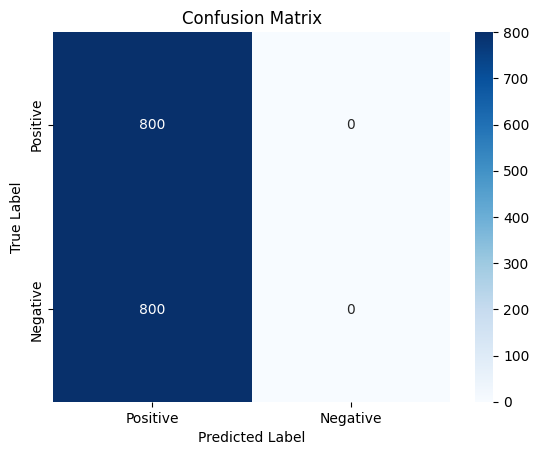

In [40]:
print(preds.size())
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(train_classes.numpy().argmax(axis=1), preds.detach().numpy().argmax(axis=1))

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()